# Population discovery

In [2]:
import scyan

Global seed set to 0


## Model fitting on incomplete knowledge

In [46]:
adata, table = scyan.data.load("poised") # Load data (automatic)

For a real use case, we remove some knowledge from the table, and we show that Scyan helps improving the table.

The modifications are the following:
- We only keep the `classical monocytes` among all the monocytes populations. We will show later on that we can retrieve the non-classical and intermediate monocytes.
- We only keep `TCD4 EM` cells instead of the two subpopulations `TCD4 EM CD27-` and `TCD4 EM CD27+`. We will show that we will also be able to go deeper inside the annotation of `TCD4 EM` cells.

In [47]:
import numpy as np

# Keep only classical monocytes
table = table.drop(['ncMonocytes', 'iMonocytes', 'cMonocytes CD14mid'], axis=0, level=0)

# Keep only T CD4 EM and remove information about CD27
table = table.rename(index={"TCD4 EM CD27-": "TCD4 EM"}, level=0)
table.loc["TCD4 EM", "CD27"] = np.nan # No information on CD27 anymore
table = table.drop("TCD4 EM CD27+", axis=0, level=0)

In [49]:
# When training for the first time on a new dataset, we advise to start with the default arguments (i.e., remove 'prior_std' and 'lr')
model = scyan.Scyan(adata, table, prior_std=0.25, lr=0.0001)
model.fit()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/scyan-5lsXrWE1-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 31.9 K
---------------------------------------
31.9 K    Trainable params
0         Non-trainable params
31.9 K    Total params
0.127     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Scyan model with N=4178320 cells, P=22 populations and M=19 markers.
   ├── No covariate provided.
   └── Batch correction mode: False

## Characterizing unknown populations
Your knowledge table may be incomplete, and some populations may be predicted as "Unknown" by Scyan. We are going to select these unknown cells and characterise them.

In [50]:
# A higher log_prob_th (i.e., closer to 0) will display more "unknown" cells.
# It helps finding cells which are not really corresponding to known ones
model.predict(log_prob_th=-20);

DataLoader:   0%|          | 0/511 [00:00<?, ?it/s]

We see some unknown cells just above the Monocytes and in the left of the DCs. They are displayed in gray (`NA` in the legend).

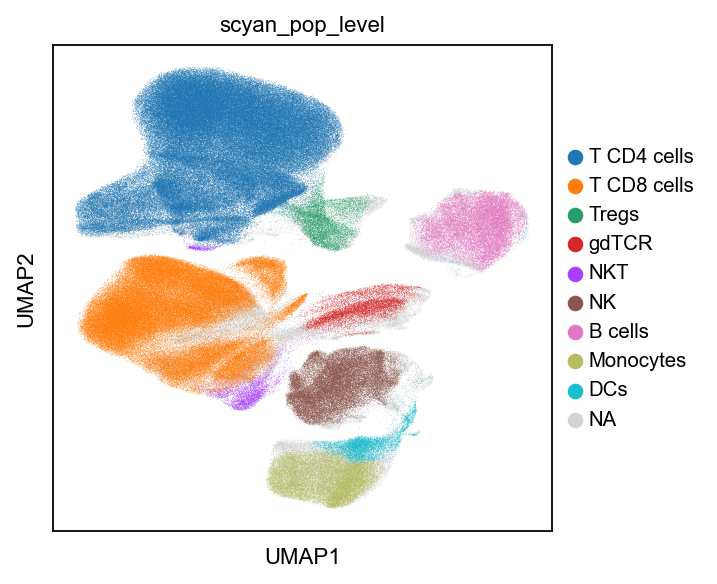

In [51]:
scyan.plot.umap(adata, color="scyan_pop_level")

### Selecting the desired unknown cells
This can simply be done by selecting the cells of interest on the UMAP. Here, We are selecting the gray cells (i.e., the unknown cells) that are just above the monocytes.

To select cells interactively, we need to change the matplotlib background. For instance, we can use `matplotlib tk`:

In [19]:
%matplotlib tk

In [20]:
selector = scyan.tools.PolygonGatingUMAP(adata)
selector.select()

Enclose cells within a polygon. Helper:
    - Click on the plot to add a polygon vertex
    - Press the 'esc' key to start a new polygon
    - Try holding the 'ctrl' key to move a single vertex
    - Once the polygon is finished and overlaid in red, you can close the window


In [21]:
selector.save_selection()

Selected 1264 cells and saved the selection in adata.obs['scyan_selected']


We go back to `matplotlib inline`

In [22]:
%matplotlib inline

### Characterise them

DataLoader:   0%|          | 0/1 [00:00<?, ?it/s]

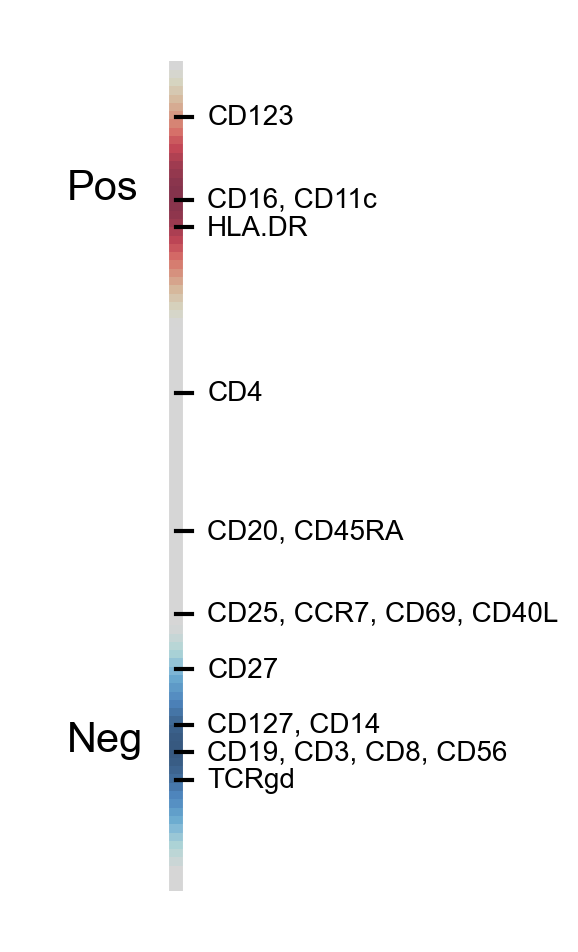

In [25]:
# Show the latent expressions of the selected cells
scyan.plot.pop_expressions(model, "selected", key="scyan_selected")

But mainly, we can show why Scyan couldn't predict a population for these cells.

The below figure shows the decomposition of Scyan confidence per population and per marker. For the cells of interest, we provide a confidence level for the prediction of each population (first column). Then, each population probability is decomposed into a sum of marker impact on the probability (one row).
Dark colours indicate that the corresponding marker expression decreased the population probability of the corresponding row. For instance, the
expression of CD14 (which is low for this population, according to above figure) decreased the confidence for predicting cMonocytes.

DataLoader:   0%|          | 0/1 [00:00<?, ?it/s]

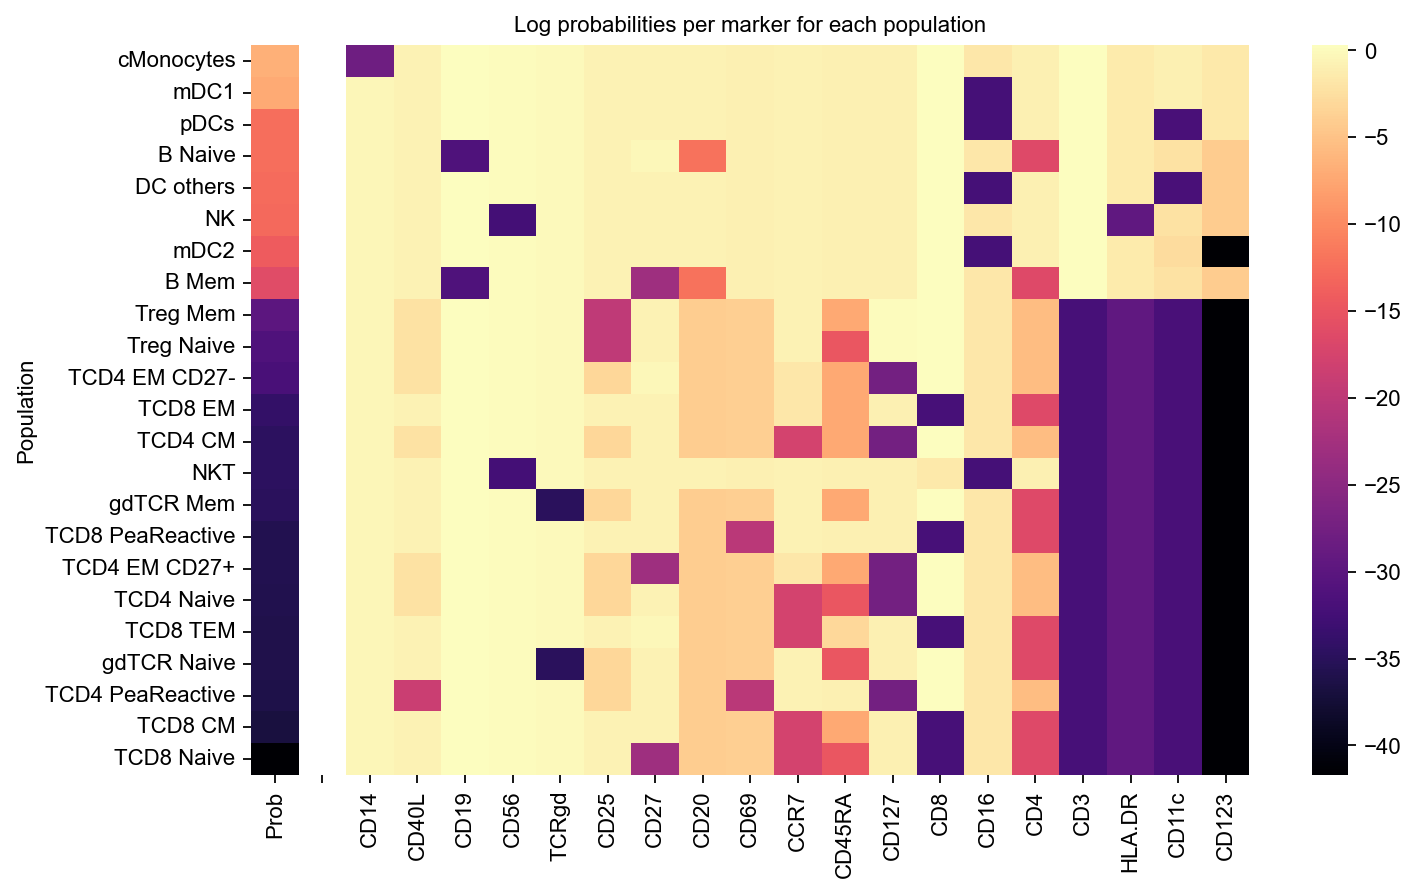

In [26]:
scyan.plot.probs_per_marker(model, "selected", key="scyan_selected")

According to these graphs, we can conclude that the "unknown" cells were non-classical/intermediate monocytes.

The next step would be to add them in the knowledge table and run Scyan again!

## Define more precise populations

You may want to go deeper in the annotations and annotate subpopulations among the one you defined. This is the purpose of this section.

> NB: you'll need an additional package: `leidenalg`. You can either install it directly (e.g., with `pip`), or install the "discovery" extra from scyan: `pip install "scyan[discovery]"`.

In [52]:
# Increase the resolution to get more clusters
scyan.tools.subcluster(adata, "TCD4 EM", resolution=0.1, markers=table.columns)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


It found 2 subclusters insides T CD4 EM cells.

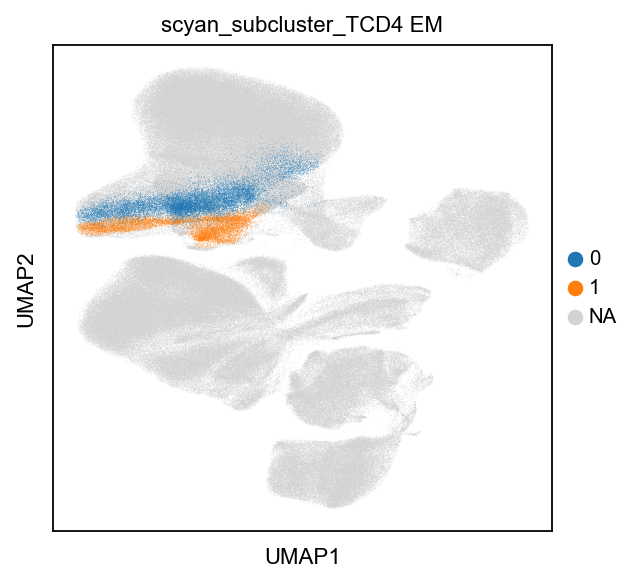

In [53]:
scyan.plot.umap(adata, "scyan_subcluster_TCD4 EM")

Below, we try to characterise the different subclusters (0 and 1) using the latent expressions.
> We remind that, a latent expression of -1 means negative, while 1 means positive.

We can see that the subcluster 0 is CD27+, and the subcluster 1 is CD27-. The next step would be to replace `TCD4 EM` by `TCD4 EM CD27-` and `TCD4 EM CD27+` in the knowledge table and run Scyan again!

DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

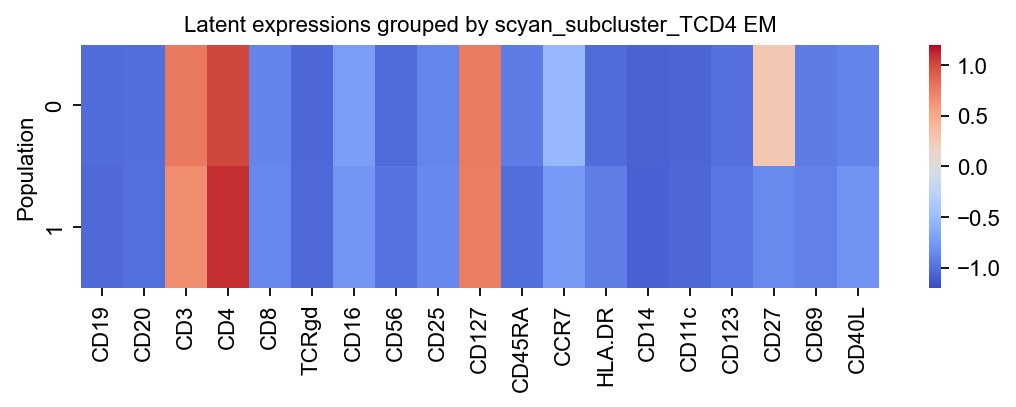

In [58]:
scyan.plot.pops_expressions(model, key="scyan_subcluster_TCD4 EM", figsize=(8, 2))